# Chunking in Natural Language Processing
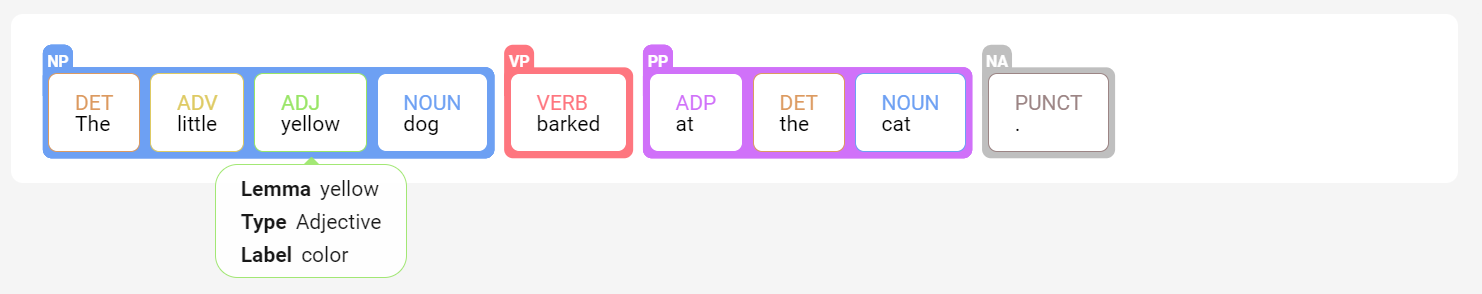

# Regex Based Chunking



`Chunk: {<DT>*<NNP>*<NN>*}` can be used for extracting the proper nouns from the sentence like: The Manchester City Football Club




In [6]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
text = "the little yellow dog barked at the cat"
tokens = nltk.word_tokenize(text)
print(tokens)

['the', 'little', 'yellow', 'dog', 'barked', 'at', 'the', 'cat']


In [8]:
tag = nltk.pos_tag(tokens)
print(tag)

[('the', 'DT'), ('little', 'JJ'), ('yellow', 'JJ'), ('dog', 'NN'), ('barked', 'VBD'), ('at', 'IN'), ('the', 'DT'), ('cat', 'NN')]


In [9]:
# Define your grammar using regular expressions
grammar = ('''
	NP: {<DT>?<JJ>*<NN>} # NP
	''')
cp = nltk.RegexpParser(grammar)
result = cp.parse(tag)
print(result)

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


In [10]:
#result.draw()

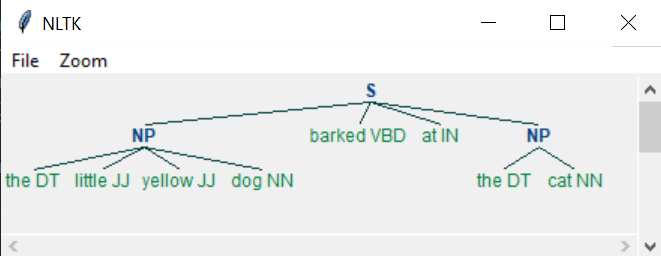

---
Nested and Cascaded Chunkers


---



In [11]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
sentence = [("Mary", "NN"), ("saw", "VBD"), ("the", "DT"), ("cat", "NN"),
    ("sit", "VB"), ("on", "IN"), ("the", "DT"), ("mat", "NN")]

In [12]:
print(cp.parse(sentence))

(S
  (NP Mary/NN)
  saw/VBD
  (CLAUSE
    (NP the/DT cat/NN)
    (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))


In [13]:
cp = nltk.RegexpParser(grammar, loop=2)
print(cp.parse(sentence))

(S
  (CLAUSE
    (NP Mary/NN)
    (VP
      saw/VBD
      (CLAUSE
        (NP the/DT cat/NN)
        (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))))


# Tagger Based Chunking

I’ve used the `conll2000` corpus for training chunker. This corpus defines the chunks using IOB tags.

```
IOB : Inside,Outside,Beginning
B- prefix before a tag indicates, it’s the beginning of a chunk
I- prefix indicates that it’s inside a chunk
O- tag indicates the token doesn’t belong to any chunk
```



In [14]:
#Here conll2000 corpus for training shallow parser model
nltk.download('conll2000')
from nltk.corpus import conll2000
data= conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]
print(len(train_data),len(test_data))
print(train_data[1])

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)



---
 Regex vs Tagger Based Chunking


---







As you can see, the following approach achieves decent results. However, we can improve on it by adopting a more data-driven approach, where we use the training corpus to find the chunk tag (I, O, or B) that is most likely for each part-of-speech tag.

In [15]:
grammar = r"NP: {<[CDJNP].*>+}"
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%




---

Introducing Chunking Utility Functions tree2conlltags & conlltags2tree

---


→ `tree2conlltags` to get triples of (word, tag, chunk tags for each token). These tuples are then finally used to train a tagger and it learns IOB tags for POS tags.

→ `conlltags2tree` to generate a parse tree from these token triples
Conlltags2tree() is reversal of tree2conlltags().

We’ll be using these functions to train our parser

In [16]:
from nltk.chunk.util import tree2conlltags,conlltags2tree
wtc=tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [17]:
tree=conlltags2tree(wtc)
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


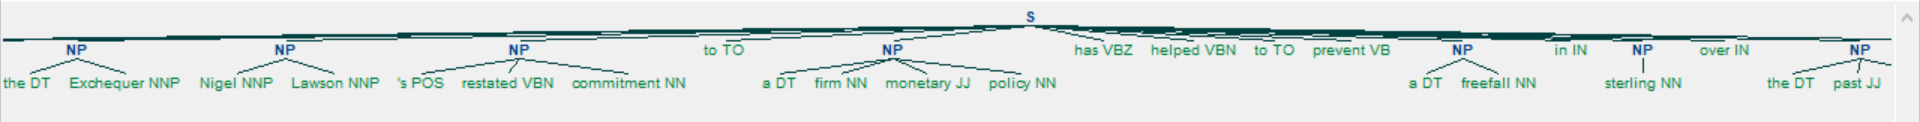

## Unigram Chunker

---



In [18]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
      train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
      self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
      pos_tags = [pos for (word,pos) in sentence]
      tagged_pos_tags = self.tagger.tag(pos_tags)
      chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
      conlltags = [(word, pos, chunktag) for ((word,pos),chunktag) in zip(sentence, chunktags)]
      return nltk.chunk.conlltags2tree(conlltags)

In [19]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [20]:
postags = sorted(set(pos for sent in train_sents for (word,pos) in sent.leaves()))
print(*unigram_chunker.tagger.tag(postags),sep='\n')

('#', 'B-NP')
('$', 'B-NP')
("''", 'O')
('(', 'O')
(')', 'O')
(',', 'O')
('.', 'O')
(':', 'O')
('CC', 'O')
('CD', 'I-NP')
('DT', 'B-NP')
('EX', 'B-NP')
('FW', 'I-NP')
('IN', 'O')
('JJ', 'I-NP')
('JJR', 'B-NP')
('JJS', 'I-NP')
('MD', 'O')
('NN', 'I-NP')
('NNP', 'I-NP')
('NNPS', 'I-NP')
('NNS', 'I-NP')
('PDT', 'B-NP')
('POS', 'B-NP')
('PRP', 'B-NP')
('PRP$', 'B-NP')
('RB', 'O')
('RBR', 'O')
('RBS', 'B-NP')
('RP', 'O')
('SYM', 'O')
('TO', 'O')
('UH', 'O')
('VB', 'O')
('VBD', 'O')
('VBG', 'O')
('VBN', 'O')
('VBP', 'O')
('VBZ', 'O')
('WDT', 'B-NP')
('WP', 'B-NP')
('WP$', 'B-NP')
('WRB', 'O')
('``', 'O')


## Bigram Chunker

---



In [21]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
      train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
      self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
      pos_tags = [pos for (word,pos) in sentence]
      tagged_pos_tags = self.tagger.tag(pos_tags)
      chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
      conlltags = [(word, pos, chunktag) for ((word,pos),chunktag) in zip(sentence, chunktags)]
      return nltk.chunk.conlltags2tree(conlltags)

In [22]:
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


## NGram Chunker

---


In [23]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [24]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI
#Define the chunker class
class NGramTagChunker(ChunkParserI):
  def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
    train_sent_tags=conll_tag_chunks(train_sentences)
    self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)
  def parse(self,tagged_sentence):
      if not tagged_sentence:
        return None
      pos_tags=[tag for word, tag in tagged_sentence]
      chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
      chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
      wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
      return conlltags2tree(wpc_tags)
#train chunker model
ntc=NGramTagChunker(train_data)
#evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [25]:
import pandas as pd
sentence='No new emoji may be released in 2021 due to COVID-19 pandemic word'
nltk_pos_tagged=nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged,columns=['word','POS tag'])

,word,POS tag
0,No,DT
1,new,JJ
2,emoji,NN
3,may,MD
4,be,VB
5,released,VBN
6,in,IN
7,2021,CD
8,due,JJ
9,to,TO


In [26]:
chunk_tree=ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP No/DT new/JJ emoji/NN)
  (VP may/MD be/VB released/VBN)
  (PP in/IN)
  (NP 2021/CD due/JJ)
  (VP to/TO)
  (NP COVID-19/JJ pandemic/JJ word/NN))


In [27]:
chunk_tree

TclError: ignored

Tree('S', [Tree('NP', [('No', 'DT'), ('new', 'JJ'), ('emoji', 'NN')]), Tree('VP', [('may', 'MD'), ('be', 'VB'), ('released', 'VBN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('2021', 'CD'), ('due', 'JJ')]), Tree('VP', [('to', 'TO')]), Tree('NP', [('COVID-19', 'JJ'), ('pandemic', 'JJ'), ('word', 'NN')])])

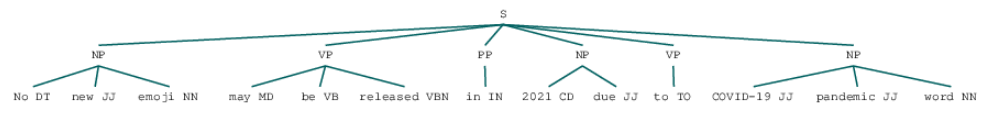